# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
!pip install imageio

In [1]:
import numpy as np
import os
from imageio import imread
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
%cd /content/gdrive/MyDrive/Colab Notebooks/

/content/gdrive/MyDrive/Colab Notebooks


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32

In [6]:
train_doc.shape

(663,)

In [7]:
val_doc.shape

(100,)

In [8]:
## check input image sizes 
from PIL import Image
import pathlib

data_dir_train = pathlib.Path("./Project_data/train")
data_dir_test = pathlib.Path('./Project_data/val')

image_count_train = len(list(data_dir_train.glob('*/*.png')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.png')))
print(image_count_test)



19890
3000


In [9]:
test = Image.fromarray(imread("./Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png"))

In [10]:
np.array(test.resize([120,120]))

array([[[119, 120, 105],
        [120, 119, 110],
        [118, 117, 109],
        ...,
        [139, 133, 125],
        [137, 133, 121],
        [135, 132, 120]],

       [[122, 125, 109],
        [121, 122, 113],
        [120, 119, 112],
        ...,
        [138, 133, 125],
        [135, 131, 120],
        [133, 130, 118]],

       [[132, 133, 117],
        [130, 131, 122],
        [130, 129, 122],
        ...,
        [136, 131, 122],
        [134, 130, 118],
        [132, 129, 118]],

       ...,

       [[122, 103,  95],
        [ 86,  61,  55],
        [ 68,  39,  33],
        ...,
        [ 63,  52,  48],
        [ 71,  49,  51],
        [ 74,  51,  53]],

       [[ 75,  61,  56],
        [ 36,  21,  19],
        [ 51,  29,  29],
        ...,
        [ 65,  53,  45],
        [ 74,  49,  49],
        [ 75,  50,  52]],

       [[ 34,  30,  26],
        [ 18,  12,  14],
        [ 31,  13,  18],
        ...,
        [ 67,  52,  45],
        [ 73,  49,  51],
        [ 73,  51,  53]]

In [ ]:
def checksize(image_filename):
    im = Image.open(image_filename)
    return im.size
    
    
arr = []
for filenames in list(data_dir_train.glob('*/*.png')):
    arr.append(checksize(filenames))

    
for filenames in list(data_dir_test.glob('*/*.png')):
    arr.append(checksize(filenames))
    
# images are of different dimensions so resizing needed before feeding to deepnet. Will resize to 120 by 120 to start with
set(arr)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [12]:
# resizing 
image_resize_height = 100
image_resize_width = 100

def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26,28]#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(folder_list.shape[0]/batch_size)
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),image_resize_width,image_resize_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = np.array(Image.fromarray(image).resize([image_resize_width,image_resize_height]))
                   # batch_data[folder,idx,:,:,0] = (image_resized[:,:,0] - min(map(min, image_resized[:,:,0])))/(max(map(max, image_resized[:,:,0]))-min(map(min, image_resized[:,:,0])))
                   # batch_data[folder,idx,:,:,1] = (image_resized[:,:,1] - min(map(min, image_resized[:,:,1])))/(max(map(max, image_resized[:,:,1]))-min(map(min, image_resized[:,:,1])))
                   # batch_data[folder,idx,:,:,2] = (image_resized[:,:,2] - min(map(min, image_resized[:,:,2])))/(max(map(max, image_resized[:,:,2]))-min(map(min, image_resized[:,:,2])))
                    batch_data[folder,idx,:,:,0] = image_resized[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image_resized[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image_resized[:,:,2]/255
   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        
        if int(folder_list.shape[0]%batch_size) > 0:
            batch_data = np.zeros(((folder_list.shape[0]%batch_size),len(img_idx),image_resize_width,image_resize_height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros(((folder_list.shape[0]%batch_size),5)) # batch_labels is the one hot representation of the output
            for folder in range(folder_list.shape[0]-(num_batches*batch_size)):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.uint8)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = np.array(Image.fromarray(image).resize([image_resize_width,image_resize_height]))
                    #batch_data[folder,idx,:,:,0] = (image_resized[:,:,0] - min(map(min, image_resized[:,:,0])))/(max(map(max, image_resized[:,:,0]))-min(map(min, image_resized[:,:,0])))
                    #batch_data[folder,idx,:,:,1] = (image_resized[:,:,1] - min(map(min, image_resized[:,:,1])))/(max(map(max, image_resized[:,:,1]))-min(map(min, image_resized[:,:,1])))
                    #batch_data[folder,idx,:,:,2] = (image_resized[:,:,2] - min(map(min, image_resized[:,:,2])))/(max(map(max, image_resized[:,:,2]))-min(map(min, image_resized[:,:,2])))
                    batch_data[folder,idx,:,:,0] = image_resized[:,:,0]/255
                    batch_data[folder,idx,:,:,1] = image_resized[:,:,1]/255
                    batch_data[folder,idx,:,:,2] = image_resized[:,:,2]/255
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers


In [15]:
help(tf.keras.layers.Conv3D)

Help on class Conv3D in module tensorflow.python.keras.layers.convolutional:

class Conv3D(Conv)
 |  Conv3D(*args, **kwargs)
 |  
 |  3D convolution layer (e.g. spatial convolution over volumes).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input to produce a tensor of
 |  outputs. If `use_bias` is True,
 |  a bias vector is created and added to the outputs. Finally, if
 |  `activation` is not `None`, it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide the keyword argument `input_shape`
 |  (tuple of integers, does not include the sample axis),
 |  e.g. `input_shape=(128, 128, 128, 1)` for 128x128x128 volumes
 |  with a single channel,
 |  in `data_format="channels_last"`.
 |  
 |  Examples:
 |  
 |  >>> # The inputs are 28x28x28 volumes with a single channel, and the
 |  >>> # batch size is 4
 |  >>> input_shape =(4, 28, 28, 28, 1)
 |  >>> x = tf.random.normal(input_shape)
 |  >>> y = 

In [16]:
## #write your model here
input_shape=(14,image_resize_width,image_resize_height,3)

model = tf.keras.Sequential([
    layers.Conv3D(32,(2,5,5),activation='relu',input_shape=input_shape),
    layers.MaxPooling3D((2, 5, 5)),
    layers.Conv3D(64,(2,5,5),activation='relu'),
    layers.MaxPooling3D((2, 5, 5)),
  #  layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(5, activation='softmax')
  
])

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
#optimiser = 'adam'
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
lr_metric = get_lr_metric(optimizer)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy',lr_metric])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 13, 96, 96, 32)    4832      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 6, 19, 19, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 15, 15, 64)     102464    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 3, 3, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               147584    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.0005)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'decay': 0.0,
 'epsilon': 1e-07,
 'learning_rate': 0.0005,
 'name': 'Adam'}

In [22]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=-1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  ./Project_data/train ; batch size = 32
Epoch 1/10
21/21 [==============================] - 3816s 189s/step - loss: 1.6558 - categorical_accuracy: 0.1866 - lr: 5.0000e-04 - val_loss: 1.5140 - val_categorical_accuracy: 0.2300 - val_lr: 5.0000e-04

Epoch 00001: saving model to model_init_2021-03-0708_49_24.564829/model-00001-1.61183-0.21116-1.51403-0.23000.h5
Epoch 2/10
21/21 [==============================] - 49s 2s/step - loss: 1.5067 - categorical_accuracy: 0.2730 - lr: 5.0000e-04 - val_loss: 1.3092 - val_categorical_accuracy: 0.5300 - val_lr: 5.0000e-04

Epoch 00002: saving model to model_init_2021-03-0708_49_24.564829/model-00002-1.45374-0.33032-1.30915-0.53000.h5
Epoch 3/10
21/21 [==============================] - 48s 2s/step - loss: 1.2479 - categorical_accuracy: 0.5391 - lr: 5.0000e-04 - val_loss: 1.0856 - val_categorical_accuracy: 0.5100 - val_lr: 5.0000e-04

Epoch 00003: saving model to model_init_2021-03-0708_49_24.564829/model-00003-1.21366-0.53846-1.08558-0.510

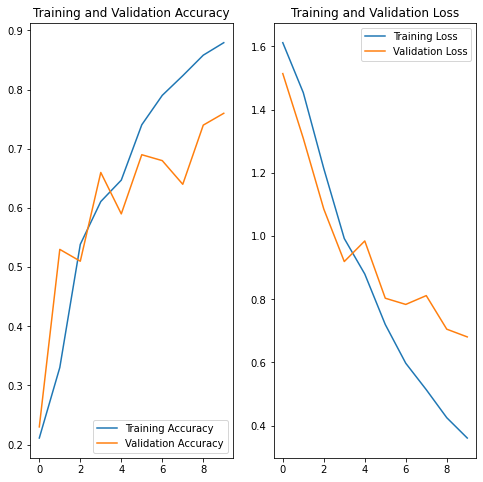

In [23]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
## testing model code

# import the opencv library 
import cv2 

vid = cv2.VideoCapture(0) 
  
while(True): 
      
    # Capture the video frame 
    # by frame 
    ret, frame = vid.read() 
  
    # Display the resulting frame 
    cv2.imshow('frame', frame) 
      
    # the 'q' button is set as the 
    # quitting button you may use any 
    # desired button of your choice 
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break
  
# After the loop release the cap object 
vid.release() 
# Destroy all the windows 
cv2.destroyAllWindows() 


In [ ]:
## preprocess test data
from PIL import Image
import cv2
img_idx = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
batch_data = np.zeros((1,len(img_idx),100,100,3))
for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
    image = cv2.imread('test5/opencv_frame_'+str(item)+'.png').astype(np.uint8)
    image_resized = np.array(Image.fromarray(image).resize([100,100]))
    batch_data[0,idx,:,:,0] = image_resized[:,:,0]/255
    batch_data[0,idx,:,:,1] = image_resized[:,:,1]/255
    batch_data[0,idx,:,:,2] = image_resized[:,:,2]/255

In [ ]:
## predict on test data
loaded_model.predict(batch_data)

In [ ]:
## predict label
loaded_model.predict_classes(batch_data)